In [ ]:
import csv

from pathlib import Path

from owlready2 import *

import pandas as pd
foodon_parsing = False

In [ ]:
pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 64.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 82.7 MB/s eta 0:00:00


In [2]:
ontology_path = "../../../data/"
error_log_path = "error_log.csv"

if parse_foodon:
    foodon_file_path = ontology_path + "/foodon_filtered.owl"
    ontology_data = get_ontology(foodon_file_path).load()
    node_prefix = "foodon"

    node_output_path = out_path / "nodes.csv"
    relation_output_path = out_path / "relations.csv"
else:
    # nourish_upper_path = ontology_path + "/test_nourishUpperOntology.owl"
    merged_ontology_path = 'nourish_merged_ontology.owl'
    ontology_data = get_ontology(merged_ontology_path).load()
    node_prefix = "upper"

    # create write paths
    node_output_path = "merged_nodes.csv"
    relation_output_path = "merged_relations.csv"


In [3]:
# Create node files
with open(node_output_path, 'w') as csvfile:
    node_fieldnames = ['node_id:ID', 'descriptive_label:string[]', 'iri', ':LABEL']
    node_writer = csv.DictWriter(csvfile, fieldnames=node_fieldnames)

    node_writer.writeheader()

with open(relation_output_path, 'w') as csvfile:
    relation_fieldnames = [':START_ID', ':END_ID', ':TYPE', 'restriction', 'restriction_value', 'label']
    relation_writer = csv.DictWriter(csvfile, fieldnames=relation_fieldnames)

    relation_writer.writeheader()

with open(error_log_path, 'w') as csvfile:
    error_fieldnames = ['class', 'known', 'unknown', 'type_err', 'iri']
    error_writer = csv.DictWriter(csvfile, fieldnames=error_fieldnames)

    error_writer.writeheader()


In [4]:
def create_transitionary_node(node_type, node_counter):
    # Generate a transitionary node identifier
    node = f"{node_type.upper()}_{node_counter}"
    node_counter += 1
    return node, node_counter

def append_node(node, node_output_path: Path, *, node_type: str = ''):
    '''
    Appends a node to the node file.

    input:
        node:
            case 1: owlready2.entity.ThingClass
            case 2: Type: str: node = string name
        node_output_path: path to the node file to append the node to
        node_type: node type for AND/OR
    '''
    # Construct node row
    if isinstance(node, owlready2.entity.ThingClass) or isinstance(node, owlready2.prop.ObjectPropertyClass) \
            or isinstance(node, owl.Thing) or isinstance(node, owl.Nothing):
        # ThingClass node
        try:
            node_label = ';'.join(node.label)
        except:
            node_label = ''
        node_line = [str(node), node_label, str(node.iri), node_type]
    elif isinstance(node, str):
        # Case: blank, and/or nodes
        node_line = [node, '', '', node_type]
    else:
        raise ValueError("Unsupported node type.")
    
    # Write node to file
    with open(node_output_path, 'a') as file:
        node_writer = csv.writer(file, delimiter=',')
        node_writer.writerow(node_line)

def append_relation(source_id: str, target_id: str,
                    edge_type: str, restriction, restriction_val):
    '''
    Appends a relation to the relation file.
    '''
    try:
        edge_label = ';'.join(edge_type.label)
    except:
        edge_label = ''

    # Construct relation row
    relation_line = [source_id, target_id, edge_type, restriction, restriction_val, edge_label]
    
    # Write to file
    with open(relation_output_path, 'a') as file:
        relation_writer = csv.writer(file, delimiter=',')
        relation_writer.writerow(relation_line)

def get_details_of_restriction(restriction):
    '''
    Extracts details of a restriction.
    '''
    return restriction.property, restriction.type, restriction.value


In [5]:
def parse_logic(unknown_node, known_node, edge_type, restriction_type, restriction_value,
                and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes):
    match unknown_node:
        case owlready2.entity.ThingClass():
            # case: stop rule
            if unknown_node.name == "Thing":
                append_node(unknown_node,node_p,node_type="Thing")
            elif unknown_node.name == "Nothing":
                append_node(unknown_node,node_p,node_type="Nothing")
            else:
                append_node(unknown_node,node_p,node_type="Concept")

            # append_node(unknown_node,node_p,node_type="Concept")
            if isinstance(known_node, str) and ("AND" in known_node or "OR" in known_node):
                # AND/OR nodes are the targets of classes in conjunctons
                append_relation(unknown_node, known_node, edge_type, restriction_type, restriction_value)
            else:
                append_relation(known_node, unknown_node, edge_type, restriction_type, restriction_value)
            if isinstance(known_node, str) and ("AND" in known_node or "OR" in known_node):
                # AND/OR nodes are the targets of classes in conjunctons
                append_relation(unknown_node, known_node, edge_type, restriction_type, restriction_value)
            else:
                append_relation(known_node, unknown_node, edge_type, restriction_type, restriction_value)
        
        case owlready2.prop.ObjectPropertyClass():
            append_node(unknown_node,node_p,node_type="Property")
            if isinstance(known_node, str) and ("AND" in known_node or "OR" in known_node):
                # AND/OR nodes are the targets of classes in conjunctons
                append_relation(known_node, unknown_node, edge_type, restriction_type, restriction_value)
            else:
                append_relation(unknown_node, known_node, edge_type, restriction_type, restriction_value)

        case owlready2.class_construct.And():
            ## AND Node creation
            and_node, and_count = create_transitionary_node(f'{node_prefix}_AND',and_count)
            append_node(and_node,node_p,node_type='AND')
            # made edge between AND and known
            append_relation(known_node, and_node, edge_type, restriction_type, restriction_value)
            
            # Iterate through AND list
            for connected_node in unknown_node.is_a:
                # make recursion call on connected node
                and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(connected_node, and_node, "member_of",
                    restriction_type, restriction_value, and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes)
                
        case owlready2.class_construct.Or():
            ## AND Node creation
            or_node, or_count = create_transitionary_node(f'{node_prefix}_OR', or_count)
            append_node(or_node,node_p,node_type='OR')
            # made edge between OR and known
            append_relation(known_node, or_node, edge_type, restriction_type, restriction_value)
            
            # Iterate through OR list
            for connected_node in unknown_node.Classes:
                # make recursion call on connected node
                and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(connected_node, or_node, "member_of",
                    restriction_type, restriction_value, and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes)

        case owlready2.class_construct.Restriction():
            ## BLANK Node Creatiom
            blank_node, blank_count = create_transitionary_node(f'{node_prefix}_BLANK', blank_count)
            append_node(blank_node, node_p, node_type='BLANK')
            # make edge between known and blank
            append_relation(blank_node, known_node, edge_type, restriction_type, restriction_value)
            
            # Get values out of restriction
            edge_label, restriction, new_unknown_type = get_details_of_restriction(unknown_node)
            restr_value = ""
            match restriction:
                case 24: # SOME
                    restriction_name = "SOME"
                case 25: # ONLY
                    restriction_name = "ONLY"
                case 26: # EXACTLY
                    restriction_name = "EXACTLY"
                    restr_value = unknown_node.cardinality
                case 27: # MIN
                    restriction_name = "MIN"
                    restr_value = unknown_node.cardinality
                case 28:
                    restriction_name = "MAX"
                    restr_value = unknown_node.cardinality
                case 29:
                    restriction_name = "VALUE"
                    restr_value = unknown_node.cardinality
                case _:
                    print(restriction)
                    print(unknown_node)
                    raise NotImplementedError
            
            assert isinstance(edge_label, owlready2.prop.ObjectPropertyClass) or \
                    isinstance(edge_label, owlready2.prop.DataPropertyClass), f"{edge_label} {type(edge_label)}"
            and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(new_unknown_type, blank_node, edge_label,
                restriction_name, restr_value, and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes)
            
        case owlready2.class_construct.Not():
            ## Not Node Creatiom
            not_node, not_count = create_transitionary_node(f'{node_prefix}_NOT', not_count)
            append_node(not_node, node_p, node_type='NOT')
            # make edge between known and blank
            append_relation(not_node, known_node, edge_type, restriction_type, restriction_value)
            
            # Get values out of restriction
            and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(unknown_node.Class, not_node, "member_of",
                restriction_type, restriction_value, and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes)
            
        case owlready2.class_construct.OneOf():
            ## OneOf Node creation
            oo_node, oo_count = create_transitionary_node(f'{node_prefix}_OneOf', oo_count)
            append_node(oo_node,node_p,node_type='OneOf')
            # made edge between OneOf and known
            append_relation(known_node, oo_node, edge_type, restriction_type, restriction_value)
            
            # Iterate through AND list
            # print(unknown_node.instances)
            for connected_node in unknown_node.instances:
                # OneOf instance returns list of instances of type OneOf node
                # therefore, we need to temporarily cast connected node to type thing class
                # types.new_class(connected_node.name, (Thing,))
                
                # make recursion call on connected node
                and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(
                    types.new_class(connected_node.name, (Thing,)), oo_node, 
                    "member_of", restriction_type, restriction_value, and_count, or_count, 
                    blank_count, not_count, oo_count, node_prefix, premature_nodes)
        case type() | bool() | None:
            # TODO remove previous node if it is blank?
            # safer option: store all unsafe connections and go in and check that there are no connections
            '''
            Tends to come from poorly defined restrictions
            Merchant Category Code -[hasMerchantCategoryDescription]->Some(str)
            Translation: Merchant category code with a valid category description of str
            example class & iri: FunctionalEntities.MerchantCategoryCode, 
            https://spec.edmcouncil.org/fibo/ontology/BE/FunctionalEntities/FunctionalEntities/MerchantCategoryCode
            Under FunctionalEntities.MerchantCategoryCode is_a:
            [ClassificationSchemes.IndustrySectorClassifier,
             LanguageRepresentation.CodeElement,
             CountryRepresentation.classifies.some(FunctionalEntities.Merchant),
             Relations.isDefinedIn.exactly(1, FunctionalEntities.MerchantCategoryCodeScheme),
             FunctionalEntities.hasMerchantCategoryDescription.some(<class 'str'>),
             LanguageRepresentation.hasTag.exactly(1, <class 'str'>)]
            '''
            premature_nodes.add(known_node)
        case owl.Thing():
            if unknown_node.name == "Nothing":
                append_node(unknown_node,node_p,node_type="Nothing")
            else:
                append_node(unknown_node,node_p,node_type="Thing")
        case _:
            # print out type
            # print(f"node: {c} Unknown type: {type(unknown_node)} on {c.iri}")
            row = [c, known_node, unknown_node, type(unknown_node), c.iri]
            with open(err_p, 'a') as f:
                err_writer = csv.writer(f, delimiter=',')
                err_writer.writerow(row)
            # pass
            raise TypeError(f"Unknown type: {type(unknown_node)}")
    return and_count, or_count, blank_count, not_count, oo_count, premature_nodes

In [6]:
def parse_logic(unknown_node, known_node, edge_type, restriction_type, restriction_value,
                and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes):
    match unknown_node:
        # Handle owl.Thing cases
        case owl.Thing():
            if unknown_node.name == "Nothing":
                append_node(unknown_node, node_output_path, node_type="Nothing")
            else:
                append_node(unknown_node, node_output_path, node_type="Thing")

        # Handle owlready2.entity.ThingClass cases
        case owlready2.entity.ThingClass():
            node_type = "Thing" if unknown_node.name == "Thing" else "Nothing" if unknown_node.name == "Nothing" else "Concept"
            append_node(unknown_node, node_output_path, node_type=node_type)

            # Add relations between nodes
            if isinstance(known_node, str) and ("AND" in known_node or "OR" in known_node):
                append_relation(unknown_node, known_node, edge_type, restriction_type, restriction_value)
            else:
                append_relation(known_node, unknown_node, edge_type, restriction_type, restriction_value)

        # Handle owlready2.prop.ObjectPropertyClass cases
        case owlready2.prop.ObjectPropertyClass():
            append_node(unknown_node, node_output_path, node_type="Property")
            if isinstance(known_node, str) and ("AND" in known_node or "OR" in known_node):
                append_relation(known_node, unknown_node, edge_type, restriction_type, restriction_value)
            else:
                append_relation(unknown_node, known_node, edge_type, restriction_type, restriction_value)

        # Handle owlready2.class_construct.And cases
        case owlready2.class_construct.And():
            and_node, and_count = create_transitionary_node(f'{node_prefix}_AND', and_count)
            append_node(and_node, node_output_path, node_type='AND')
            append_relation(known_node, and_node, edge_type, restriction_type, restriction_value)
            for sub_node in unknown_node.is_a:
                and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(
                    sub_node, and_node, "member_of", restriction_type, restriction_value,
                    and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes
                )

        # Handle owlready2.class_construct.Or cases
        case owlready2.class_construct.Or():
            or_node, or_count = create_transitionary_node(f'{node_prefix}_OR', or_count)
            append_node(or_node, node_output_path, node_type='OR')
            append_relation(known_node, or_node, edge_type, restriction_type, restriction_value)
            for sub_node in unknown_node.Classes:
                and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(
                    sub_node, or_node, "member_of", restriction_type, restriction_value,
                    and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes
                )

        # Handle owlready2.class_construct.Restriction cases
        case owlready2.class_construct.Restriction():
            blank_node, blank_count = create_transitionary_node(f'{node_prefix}_BLANK', blank_count)
            append_node(blank_node, node_output_path, node_type='BLANK')
            append_relation(blank_node, known_node, edge_type, restriction_type, restriction_value)

            edge_label, restriction, new_node = get_details_of_restriction(unknown_node)
            restriction_name = {24: "SOME", 25: "ONLY", 26: "EXACTLY", 27: "MIN", 28: "MAX", 29: "VALUE"}.get(restriction, None)
            restr_value = getattr(unknown_node, 'cardinality', '') if restriction in {26, 27, 28, 29} else ""

            assert restriction_name, f"Unknown restriction: {restriction}"
            and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(
                new_node, blank_node, edge_label, restriction_name, restr_value,
                and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes
            )

        # Handle owlready2.class_construct.Not cases
        case owlready2.class_construct.Not():
            not_node, not_count = create_transitionary_node(f'{node_prefix}_NOT', not_count)
            append_node(not_node, node_output_path, node_type='NOT')
            append_relation(not_node, known_node, edge_type, restriction_type, restriction_value)
            and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(
                unknown_node.Class, not_node, "member_of", restriction_type, restriction_value,
                and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes
            )

        # Handle owlready2.class_construct.OneOf cases
        case owlready2.class_construct.OneOf():
            oo_node, oo_count = create_transitionary_node(f'{node_prefix}_OneOf', oo_count)
            append_node(oo_node, node_output_path, node_type='OneOf')
            append_relation(known_node, oo_node, edge_type, restriction_type, restriction_value)
            for sub_node in unknown_node.instances:
                and_count, or_count, blank_count, not_count, oo_count, premature_nodes = parse_logic(
                    types.new_class(sub_node.name, (Thing,)), oo_node,
                    "member_of", restriction_type, restriction_value,
                    and_count, or_count, blank_count, not_count, oo_count, node_prefix, premature_nodes
                )

        # Handle unsupported types and add to premature nodes
        case type() | bool() | None:
            premature_nodes.add(known_node)

        # Handle unknown types
        case _:
            with open(error_log_path, 'a') as file:
                err_writer = csv.writer(file, delimiter=',')
                err_writer.writerow([unknown_node, known_node, type(unknown_node), unknown_node.iri])
            raise TypeError(f"Unknown type: {type(unknown_node)}")

    return and_count, or_count, blank_count, not_count, oo_count, premature_nodes


152it [00:00, 719.56it/s]

:(


5268it [00:04, 1351.58it/s]* Owlready2 * Warning: ignoring cyclic subclass of/subproperty of, involving:
  http://purl.obolibrary.org/obo/FOODON_00002511

11347it [00:09, 1311.20it/s]* Owlready2 * Warning: ignoring cyclic subclass of/subproperty of, involving:
  http://purl.obolibrary.org/obo/FOODON_03315876

33414it [00:21, 1555.83it/s]


In [7]:
node_df = pd.read_csv(node_output_path)
print(node_df.shape)
node_df.drop_duplicates(subset='node_id:ID', inplace=True)
node_df.to_csv(node_output_path, index=False)
print(node_df.shape)

relation_df = pd.read_csv(relation_output_path)
print(relation_df.shape)
relation_df.drop_duplicates(inplace=True)
relation_df.to_csv(relation_output_path, index=False)
print(relation_df.shape)


(100102, 4)


(50319, 4)

In [12]:
relation_df

,:START_ID,:END_ID,:TYPE,restriction,restriction_value,label
0,owl.Nothing,owl.Thing,is_a,NaN,NaN,NaN
2,obo.BFO_0000002,obo.BFO_0000001,is_a,NaN,NaN,NaN
4,UPPER_BLANK_0,obo.BFO_0000002,is_a,NaN,NaN,NaN
5,UPPER_BLANK_0,obo.BFO_0000002,obo.BFO_0000050,ONLY,NaN,part of;part of;part_of
7,UPPER_BLANK_1,obo.BFO_0000002,is_a,NaN,NaN,NaN
...,...,...,...,...,...,...
113961,Loans.hasTotalClosingCosts,Loans.hasCost,subproperty_of,NaN,NaN,NaN
113962,Loans.hasTotalPointsAndFees,Loans.hasCost,subproperty_of,NaN,NaN,NaN
113963,DebtInstruments.hasCallFeature,DebtInstruments.hasRepaymentTerms,subproperty_of,NaN,NaN,NaN
113964,DebtInstruments.hasPutFeature,DebtInstruments.hasRepaymentTerms,subproperty_of,NaN,NaN,NaN


In [15]:
from neo4j import GraphDatabase
import csv
from tqdm import tqdm
# Neo4j connection details
##uri = "bolt://67.58.49.61:7687"
##uri = "bolt://67.58.49.61:7474"
uri = "bolt://67.58.49.57:7687"

username = "neo4j"
password = "t6pniz4w"

# CSV file paths
node_file = "merged_nodes.csv"
rel_file = "merged_rel.csv"

# Function to delete all existing data
def clear_database(session):
    session.run("MATCH (n) DETACH DELETE n")
    print("Existing data cleared from the database.")

# Function to load nodes
def load_nodes(session, node_file):
    with open(node_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            query = """
            CREATE (n:Node {id: $id, name: $name, other_property: $other_property})
            """
            session.run(query, id=row['node_id:ID'], name=row['descriptive_label:string[]'], other_property=row.get('other_property', None))
            ##session.run(query, id=row['id'], name=row['name'], other_property=row.get('other_property', None))
# Function to load relationships
def load_relationships(session, rel_file):
    with open(rel_file, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            query = """
            MATCH (a:Node {id: $start_id}), (b:Node {id: $end_id})
            CREATE (a)-[:RELATES_TO {type: $type}]->(b)
            """
            session.run(query, start_id=row[':START_ID'], end_id=row[':END_ID'], type=row[':TYPE'])

driver = GraphDatabase.driver(uri, auth=(username, password))

try:
    with driver.session() as session:
        clear_database(session)

        load_nodes(session, node_file)
        load_relationships(session, rel_file)
        print("Data import completed successfully!")
finally:
    driver.close()

Existing data cleared from the database.
Data import completed successfully!


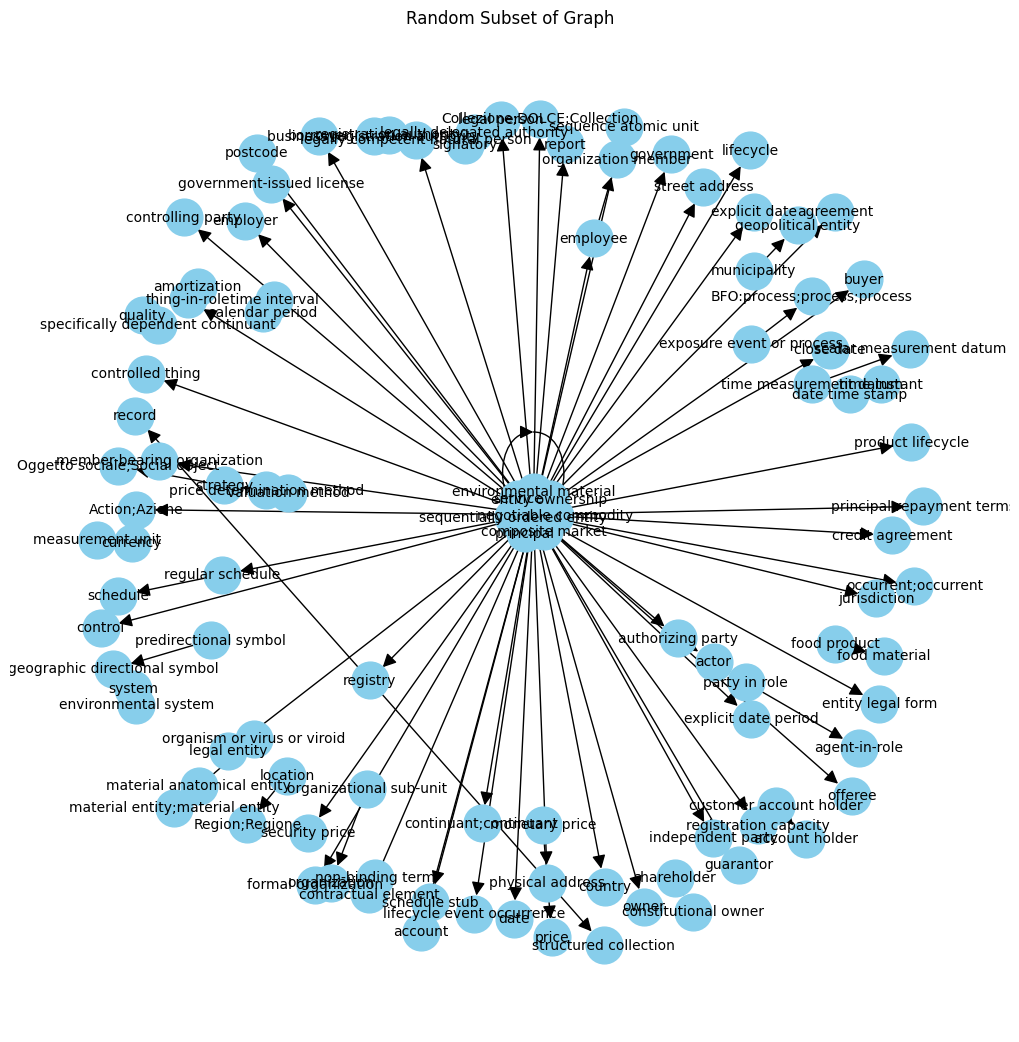

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
from neo4j import GraphDatabase

# Neo4j connection
uri = "bolt://67.58.49.57:7687"
username = "neo4j"
password = "t6pniz4w"

driver = GraphDatabase.driver(uri, auth=(username, password))

# Function to fetch a random subset of graph data
def fetch_graph_data(query):
    with driver.session() as session:
        result = session.run(query)
        edges = []
        for record in result:
            source = record["source"]
            target = record["target"]
            edges.append((source, target))
        return edges

# Cypher query to sample a subset of the graph
cypher_query = """
MATCH (a)-[r]->(b)
WHERE rand() < 0.1
RETURN a.name AS source, b.name AS target
LIMIT 100
"""

# Fetch random subset of graph data
edges = fetch_graph_data(cypher_query)

# Create a NetworkX graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    with_labels=True,
    node_size=700,
    node_color="skyblue",
    font_size=10,
    font_color="black",
    arrowsize=20
)
plt.title("Random Subset of Graph")
plt.show()